<a href="https://colab.research.google.com/github/astrapi69/DroidBallet/blob/master/DLG_D3_T3_CNN_training_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a target="_blank" href="https://academy.constructor.org/"><img src="https://jobtracker.ai/static/media/constructor_academy_colour.b86fa87f.png" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____


<center>Constructor Academy, 2024</center>


# Image classification (Live Coding)

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [ ]:
!nvidia-smi

Thu Oct  5 07:02:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 3s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
!sudo apt-get install tree

Reading package lists... Done


In [ ]:
!tree --dirsfirst --filelimit 6 '/root/.keras/datasets/flower_photos'

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

Here are some roses:

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [ ]:
PIL.Image.open(str(roses[1]))

And some tulips:

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

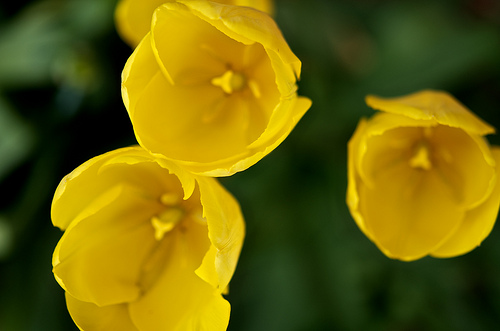

In [ ]:
PIL.Image.open(str(tulips[1]))

## Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=42,
  class_names=classes,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=42,
  class_names=classes,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order by default but we have set our own order with the `class_names` parameter.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

A naive implementation with no caching or prefetching leads to the following:

![](https://www.tensorflow.org/guide/images/data_performance/naive.svg)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

![](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(2569).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocesing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Or, you can include the layer inside your model definition, which can simplify deployment. We will use the second approach here.

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = 5

model = Sequential([

  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),

  layers.Dense(num_classes, activation='softmax')

])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model.summary()

## Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly). These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

In [ ]:
2569 // 32

80

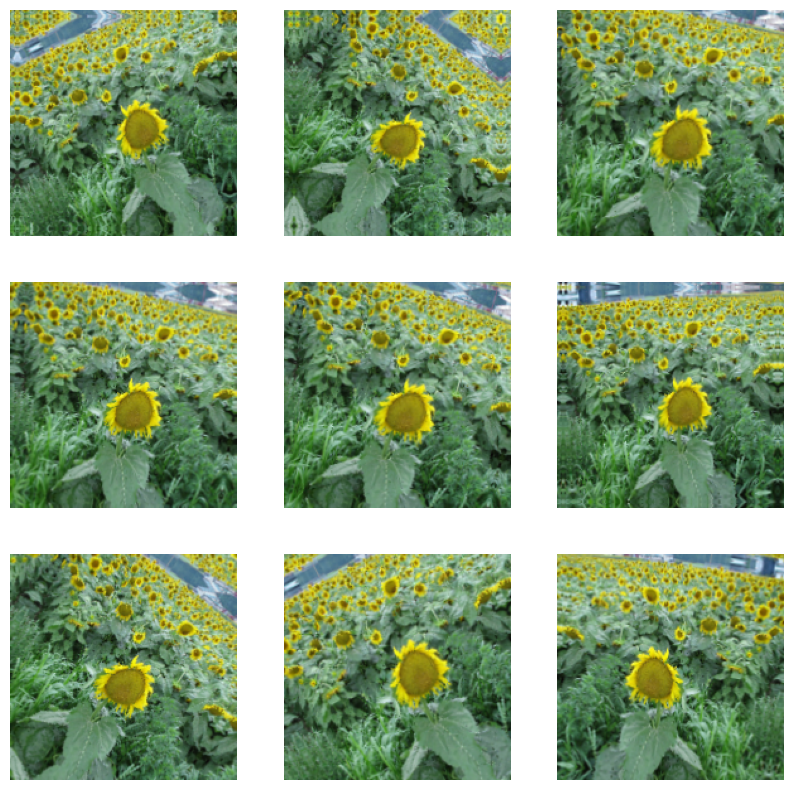

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [ ]:
model = Sequential([

  data_augmentation,

  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),

  layers.Dense(num_classes, activation='softmax')
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
81/81 [==============================] - 4s 19ms/step - loss: 1.3088 - accuracy: 0.4554 - val_loss: 1.0416 - val_accuracy: 0.5976
Epoch 2/15
81/81 [==============================] - 1s 17ms/step - loss: 1.0290 - accuracy: 0.5975 - val_loss: 0.9629 - val_accuracy: 0.6349
Epoch 3/15
81/81 [==============================] - 1s 17ms/step - loss: 0.9261 - accuracy: 0.6357 - val_loss: 0.9022 - val_accuracy: 0.6530
Epoch 4/15
81/81 [==============================] - 1s 16ms/step - loss: 0.8265 - accuracy: 0.6843 - val_loss: 0.8305 - val_accuracy: 0.6939
Epoch 5/15
81/81 [==============================] - 1s 17ms/step - loss: 0.7727 - accuracy: 0.7042 - val_loss: 0.8229 - val_accuracy: 0.6975
Epoch 6/15
81/81 [==============================] - 1s 17ms/step - loss: 0.7493 - accuracy: 0.7084 - val_loss: 0.9796 - val_accuracy: 0.6558
Epoch 7/15
81/81 [==============================] - 1s 17ms/step - loss: 0.7081 - accuracy: 0.7337 - val_loss: 0.8113 - val_accuracy: 0.7021
Epoch 8/15
81

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

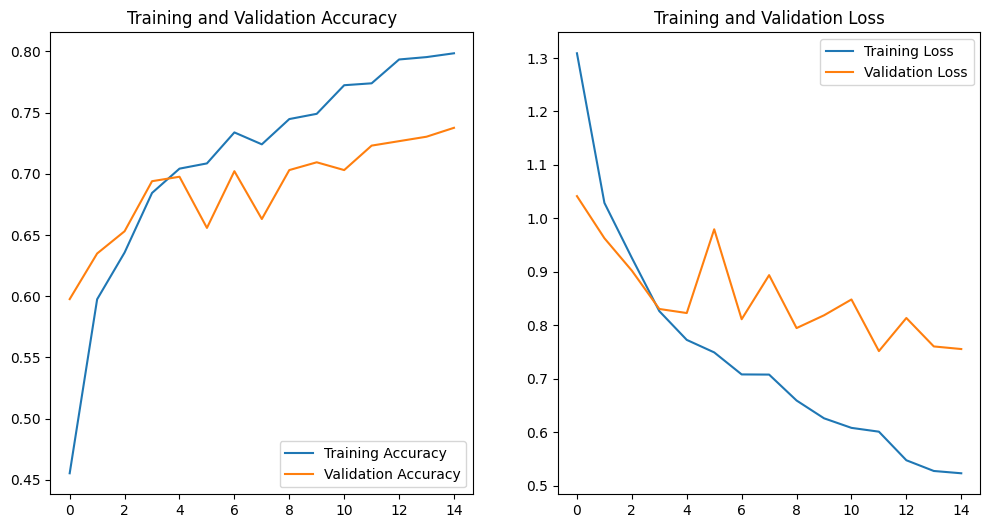

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

117948/117948 [==============================] - 0s 2us/step


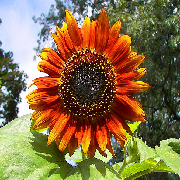

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img

In [ ]:
keras.preprocessing.image.img_to_array(img).shape

(180, 180, 3)

In [ ]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
predictions

1/1 [==============================] - 0s 149ms/step


array([[1.0306688e-06, 1.3631408e-05, 1.4895891e-05, 9.9815971e-01,
        1.8107832e-03]], dtype=float32)

In [ ]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

This image most likely belongs to sunflowers with a 99.82 percent confidence.


## Create the base model from the pre-trained convnets
You will create the base model from the **ResNet50** model developed at Microsoft. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `dogs` and `fruits`. This base of knowledge will help us classify flowers from our specific dataset.

First, you need to pick which layer of ResNet50 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
(img_height, img_width, 3,)

(180, 180, 3)

In [ ]:
IMG_SHAPE = (img_height, img_width, 3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


This feature extractor converts each `180x180x3` image into a `6x6x2048` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape

TensorShape([32, 180, 180, 3])

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


## Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_c

In [ ]:
base_model.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> False
con

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

### Add a classification head

To generate predictions from the block of features, average over the spatial 6x6 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.



In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. We then use a `sigmoid` activation to get the class probabilities

In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Build Model Architecture

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

### Rescale pixel values

We will use the correct ResNet preprocessing function to pre-process any new images where the images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

Check more details here: https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input

In [ ]:
IMG_SHAPE

(180, 180, 3)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

aug_img = data_augmentation(inputs)

pre_img = tf.keras.applications.resnet.preprocess_input(aug_img)

# important: training=False if you dont want to finetune batchnorm layers
res_model_fm = base_model(pre_img, training=False)

feature_vecs = tf.keras.layers.GlobalAveragePooling2D()(res_model_fm)

dense1 = tf.keras.layers.Dense(256)(feature_vecs)

drop1 = tf.keras.layers.Dropout(0.2)(dense1)

outputs = tf.keras.layers.Dense(5, activation='softmax')(drop1)

model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                    

In [ ]:
for layer in model.layers:
    print(layer.name, '->', layer.trainable)

input_2 -> True
sequential_1 -> True
tf.__operators__.getitem -> True
tf.nn.bias_add -> True
resnet50 -> False
global_average_pooling2d_1 -> True
dense_5 -> True
dropout_1 -> True
dense_6 -> True


In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

35/35 [==============================] - 2s 21ms/step - loss: 3.0048 - accuracy: 0.2252
initial loss: 3.00
initial accuracy: 0.23


### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
81/81 [==============================] - 6s 26ms/step - loss: 0.9430 - accuracy: 0.6676 - val_loss: 0.4704 - val_accuracy: 0.8302
Epoch 2/10
81/81 [==============================] - 2s 23ms/step - loss: 0.4654 - accuracy: 0.8264 - val_loss: 0.4083 - val_accuracy: 0.8520
Epoch 3/10
81/81 [==============================] - 2s 23ms/step - loss: 0.3497 - accuracy: 0.8708 - val_loss: 0.3810 - val_accuracy: 0.8601
Epoch 4/10
81/81 [==============================] - 2s 23ms/step - loss: 0.3127 - accuracy: 0.8844 - val_loss: 0.3495 - val_accuracy: 0.8828
Epoch 5/10
81/81 [==============================] - 2s 23ms/step - loss: 0.2750 - accuracy: 0.8988 - val_loss: 0.3422 - val_accuracy: 0.8765
Epoch 6/10
81/81 [==============================] - 2s 23ms/step - loss: 0.2520 - accuracy: 0.9027 - val_loss: 0.3444 - val_accuracy: 0.8847
Epoch 7/10
81/81 [==============================] - 2s 23ms/step - loss: 0.2179 - accuracy: 0.9171 - val_loss: 0.3273 - val_accuracy: 0.8847
Epoch 8/10
81

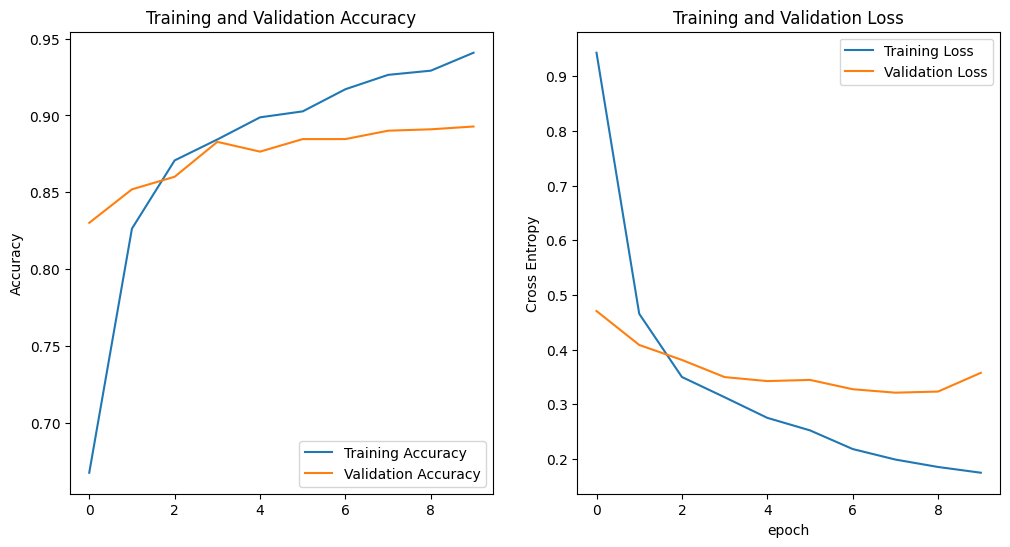

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

__Note:__ If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an ResNet50 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole ResNet50 model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_c

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> False
con

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
base_learning_rate/10

1e-05

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                    

In [ ]:
for layer in model.layers:
    print(layer.name, '->', layer.trainable)

input_2 -> True
sequential_1 -> True
tf.__operators__.getitem -> True
tf.nn.bias_add -> True
resnet50 -> True
global_average_pooling2d_1 -> True
dense_5 -> True
dropout_1 -> True
dense_6 -> True


### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
81/81 [==============================] - 23s 58ms/step - loss: 0.1712 - accuracy: 0.9439 - val_loss: 0.3254 - val_accuracy: 0.8974
Epoch 11/20
81/81 [==============================] - 3s 39ms/step - loss: 0.1135 - accuracy: 0.9552 - val_loss: 0.2833 - val_accuracy: 0.9155
Epoch 12/20
81/81 [==============================] - 3s 39ms/step - loss: 0.0726 - accuracy: 0.9766 - val_loss: 0.3137 - val_accuracy: 0.9083
Epoch 13/20
81/81 [==============================] - 3s 39ms/step - loss: 0.0519 - accuracy: 0.9825 - val_loss: 0.3288 - val_accuracy: 0.9101
Epoch 14/20
81/81 [==============================] - 3s 40ms/step - loss: 0.0450 - accuracy: 0.9860 - val_loss: 0.3440 - val_accuracy: 0.9037
Epoch 15/20
81/81 [==============================] - 3s 41ms/step - loss: 0.0424 - accuracy: 0.9887 - val_loss: 0.3030 - val_accuracy: 0.9119
Epoch 16/20
81/81 [==============================] - 3s 39ms/step - loss: 0.0325 - accuracy: 0.9887 - val_loss: 0.3582 - val_accuracy: 0.9092
Epoch

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the ResNet50 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original ResNet50 dataset.


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

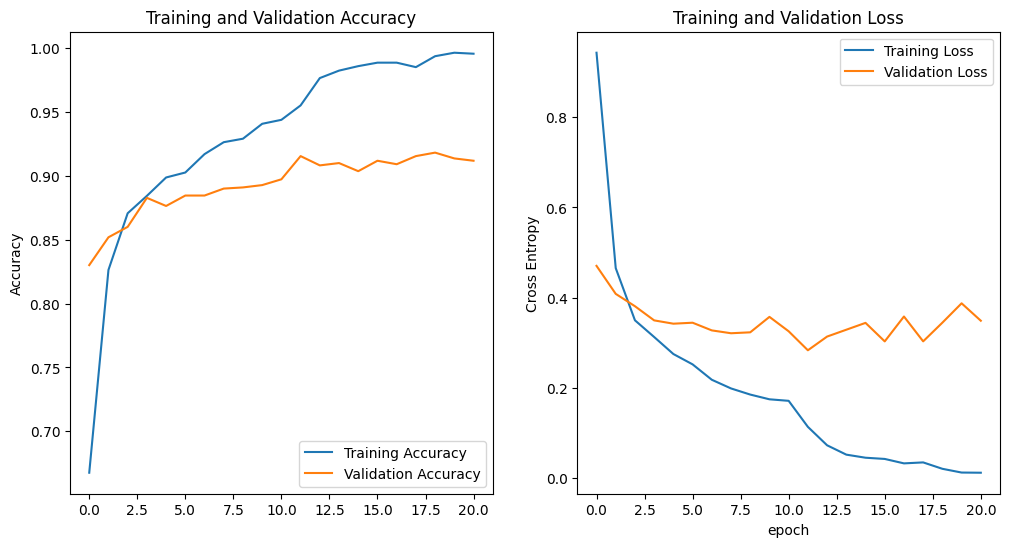

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
